In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [2]:
# The unit of the metric from the knative dashboard is falsely labeled as seconds. It is actually in the used CPU cores.
def to_used_cpu_cores(val):
    if pd.isna(val):
        return None
    val = str(val).strip().lower()

    if val.endswith("ms"):
        return float(val.replace("ms", "").strip()) / 1000.0
    elif val.endswith("µs") or val.endswith("us"):  # handle µs or us
        return float(val.replace("µs", "").replace("us", "").strip()) / 1_000_000.0
    elif val.endswith("s"):
        return float(val.replace("s", "").strip())
    else:
        # assume it's already s
        return float(val)


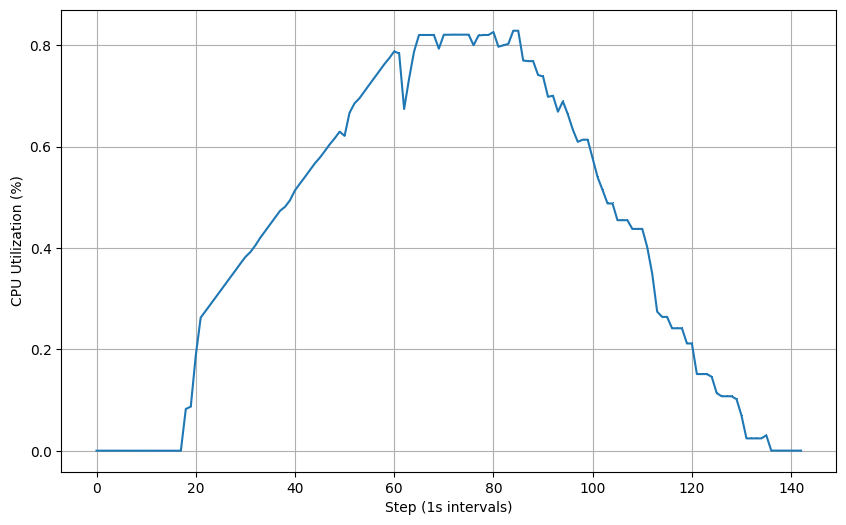

In [3]:
# CPU Utilization Auto

# Load all CSV files
# Load CSVs
csv_files_auto_cpu = glob.glob("./data/auto/*resources.csv")

dfs_auto_cpu = []
for file in csv_files_auto_cpu:
    df = pd.read_csv(file, usecols=["cpu_user-container"])
    df["cpu_user-container"] = df["cpu_user-container"].apply(to_used_cpu_cores)
    dfs_auto_cpu.append(df)

# Combine into one DataFrame
combined_auto = pd.concat(dfs_auto_cpu, axis=1)

means_auto = combined_auto["cpu_user-container"].mean(axis=1)

plt.figure(figsize=(10,6))

plt.plot(means_auto.index, means_auto, marker=",")

plt.xlabel("Step (1s intervals)")
plt.ylabel("CPU Utilization (%)")
plt.grid(True)
plt.show()



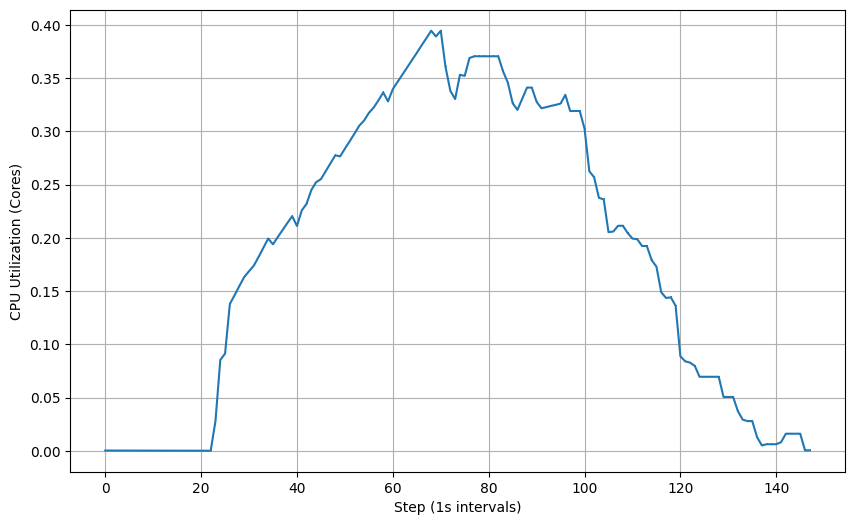

In [4]:
# CPU Utilization GPU mode

# Load all CSV files
csv_files_gpu = glob.glob("./data/gpu/*resources.csv")

# clean
dfs_gpu = []
for file in csv_files_gpu:
    df = pd.read_csv(file, usecols=["cpu_user-container"])
    df["cpu_user-container"] = df["cpu_user-container"].apply(to_used_cpu_cores)
    dfs_gpu.append(df)


combined_gpu = pd.concat(dfs_gpu, axis=1)
combined_gpu.fillna(0)

means_gpu = combined_gpu.mean(axis=1)

pd.set_option('display.max_rows', None)

plt.figure(figsize=(10,6))

# only between index 200 and 400
# means_cpu = means_cpu[25:75]

plt.plot(means_gpu.index, means_gpu, marker=",")

plt.xlabel("Step (1s intervals)")
plt.ylabel("CPU Utilization (Cores)")
# plt.legend()
plt.grid(True)
plt.show()

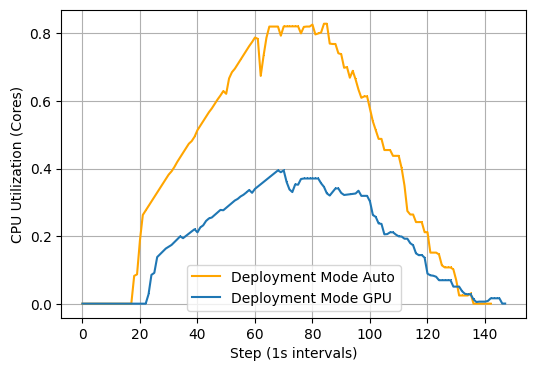

In [8]:
plt.figure(figsize=(6,4))

plt.plot(means_auto.index, means_auto,
         marker=",", label="Deployment Mode Auto", color="orange")

plt.plot(means_gpu.index, means_gpu, marker=",", label="Deployment Mode GPU", color="tab:blue")



plt.xlabel("Step (1s intervals)")
plt.ylabel("CPU Utilization (Cores)")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Export to csv

df_lines = pd.DataFrame({
    "GPU": means_gpu,
    "AUTO": means_auto,
})

# Save to CSV
df_lines.to_csv("cpu.csv", index_label="Index")

In [7]:
# Get cost rates

cpu_rate = 0.000034  # per second per vCPU

mean_cpu_cpu = means_auto.mean()  # since auto mode is always on CPU
mean_cpu_gpu = means_gpu.mean()

print(f"Mean CPU Cpu: {mean_cpu_cpu}")
print(f"Mean CPU GPU: {mean_cpu_gpu}")

cost_cpu = mean_cpu_cpu * cpu_rate
cost_gpu = mean_cpu_gpu * cpu_rate
print(f"Estimated cost per second in CPU mode: ${cost_cpu:.8f}")
print(f"Estimated cost per second in GPU mode: ${cost_gpu:.8f}")

Mean CPU Cpu: 0.42191585198135206
Mean CPU GPU: 0.1859565507882883
Estimated cost per second in CPU mode: $0.00001435
Estimated cost per second in GPU mode: $0.00000632
